In [3]:
import PyPDF2

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
        return text

pdf_path = 'weatherrecord.pdf'
extracted_text = extract_text_from_pdf(pdf_path)
print(extracted_text)


U.S. Department of Commerce National Centers for Environmental Information
National Oceanic & Atmospheric Administration 151 Patton Avenue
National Environmental Satellite, Data, and Information Service Asheville, North Carolina 28801
Current Location: Elev: 7 ft. Lat: 34.9524° S Lon: 138.5204° E
Station: ADELAIDE AIRPORT, AS ASN00023034Record of Climatological 
Observations 
These data are quality controlled and may not 
be identical to the original observations. 
Generated on 08/29/2024Observation Time Temperature: Unknown Observation Time Precipitation: Unknown
Temperature (F) Precipitation Evaporation "Soil Temperature (F)"
"24 Hrs. Ending at 
Observation Time"24 Hour Amounts Ending at 
Observation TimeAt Obs. 
Time4 in. Depth 8 in. Depth
Y 
e 
a 
rM 
o 
n 
t 
hD 
a 
y
Max. Min.At 
Obs.Rain, 
Melted 
Snow, Etc. 
(in)F 
l 
a 
gSnow, Ice 
Pellets, 
Hail (in)F 
l 
a 
gSnow, Ice 
Pellets, 
Hail, Ice 
on 
Ground 
(in)24 Hour 
Wind 
Movement 
(mi)Amount of 
Evap. (in) Ground 
Cover 
(see

In [4]:
import pandas as pd
import re

def parse_weather_data(extracted_text):
    lines = extracted_text.splitlines()
    data = []
    
    for line in lines:
        # Match lines that start with a year (e.g., "1990 01 01 ...")
        match = re.match(r'(\d{4})\s+(\d{2})\s+(\d{2})\s+(\d+)\s+(\d+)\s+(\d+\.\d+)?', line)
        if match:
            year, month, day, max_temp, min_temp, precip = match.groups()
            data.append({
                'Year': int(year),
                'Month': int(month),
                'Day': int(day),
                'Max Temp (F)': int(max_temp),
                'Min Temp (F)': int(min_temp),
                'Precipitation (in)': float(precip) if precip else None
            })
    
    return pd.DataFrame(data)

# Use the extracted text from your previous step
weather_data_df = parse_weather_data(extracted_text)

# Show the first few rows
print(weather_data_df.head())


   Year  Month  Day  Max Temp (F)  Min Temp (F)  Precipitation (in)
0  1990      1    1            92            61                 0.0
1  1990      1    2           107            62                 0.0
2  1990      1    3            83            72                 0.0
3  1990      1    4            76            57                 0.0
4  1990      1    5            75            59                 0.0


In [5]:
# Drop rows with missing temperature data
weather_data_df.dropna(subset=['Max Temp (F)', 'Min Temp (F)'], inplace=True)

# Convert temperatures to Celsius if needed
weather_data_df['Max Temp (C)'] = (weather_data_df['Max Temp (F)'] - 32) * 5.0/9.0
weather_data_df['Min Temp (C)'] = (weather_data_df['Min Temp (F)'] - 32) * 5.0/9.0

# Show cleaned data
print(weather_data_df.head())


   Year  Month  Day  Max Temp (F)  Min Temp (F)  Precipitation (in)  \
0  1990      1    1            92            61                 0.0   
1  1990      1    2           107            62                 0.0   
2  1990      1    3            83            72                 0.0   
3  1990      1    4            76            57                 0.0   
4  1990      1    5            75            59                 0.0   

   Max Temp (C)  Min Temp (C)  
0     33.333333     16.111111  
1     41.666667     16.666667  
2     28.333333     22.222222  
3     24.444444     13.888889  
4     23.888889     15.000000  


In [6]:
# Save to CSV
weather_data_df.to_csv('adelaide_weather_data.csv', index=False)

# Basic analysis example
print(weather_data_df.describe())


               Year         Month           Day  Max Temp (F)  Min Temp (F)  \
count  12409.000000  12409.000000  12409.000000  12409.000000  12409.000000   
mean    2006.496333      6.521154     15.726005     71.226851     53.421146   
std        9.806477      3.449094      8.800315     11.455146      8.552786   
min     1990.000000      1.000000      1.000000     49.000000     31.000000   
25%     1998.000000      4.000000      8.000000     62.000000     47.000000   
50%     2006.000000      7.000000     16.000000     69.000000     53.000000   
75%     2015.000000     10.000000     23.000000     78.000000     59.000000   
max     2023.000000     12.000000     31.000000    114.000000     92.000000   

       Precipitation (in)  Max Temp (C)  Min Temp (C)  
count        12409.000000  12409.000000  12409.000000  
mean             0.046363     21.792695     11.900637  
std              0.137858      6.363970      4.751548  
min              0.000000      9.444444     -0.555556  
25%     

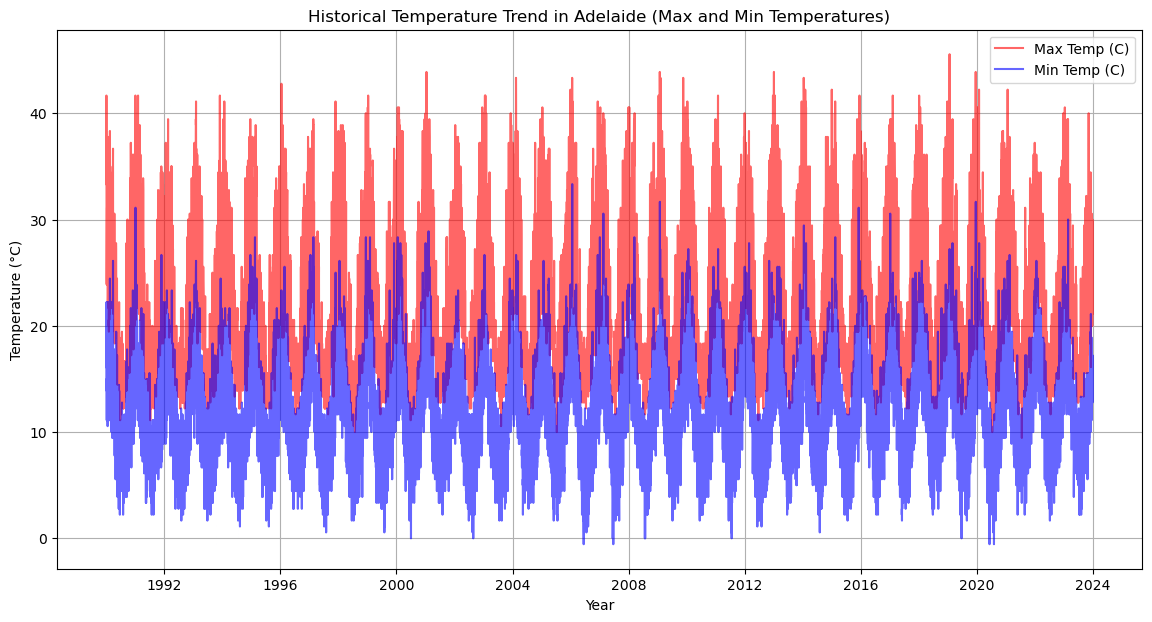

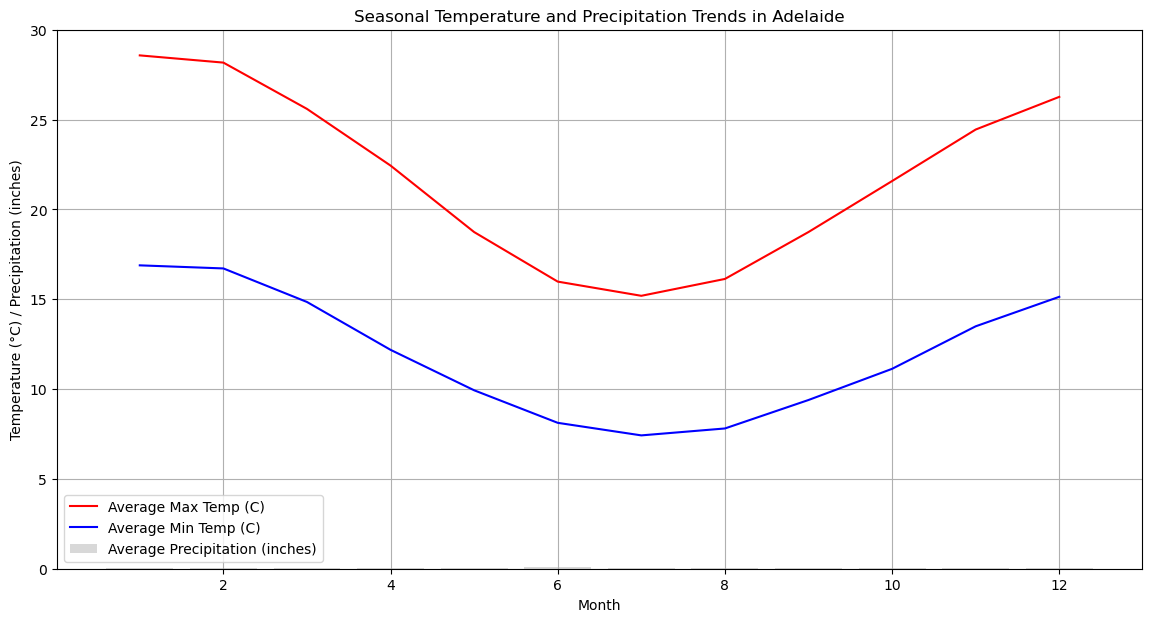

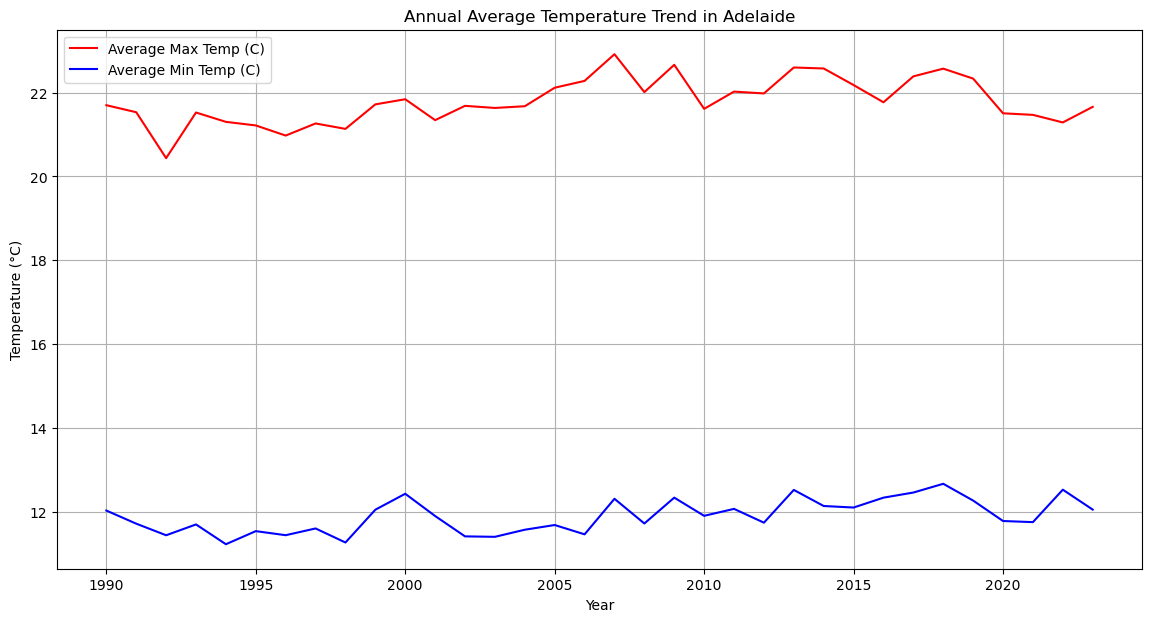

KeyboardInterrupt: 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle

# Load the weather data (assuming you have already processed and saved it as 'adelaide_weather_data.csv')
weather_data_df = pd.read_csv('adelaide_weather_data.csv')

# Feature Engineering: Adding Day of the Year for more seasonality insights
weather_data_df['Date'] = pd.to_datetime(weather_data_df[['Year', 'Month', 'Day']])
weather_data_df['DayOfYear'] = weather_data_df['Date'].dt.dayofyear

# 1. Historical Weather Trend Analysis

plt.figure(figsize=(14, 7))

# Plotting max temperatures over the years
plt.plot(weather_data_df['Date'], weather_data_df['Max Temp (C)'], label='Max Temp (C)', color='red', alpha=0.6)
# Plotting min temperatures over the years
plt.plot(weather_data_df['Date'], weather_data_df['Min Temp (C)'], label='Min Temp (C)', color='blue', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Historical Temperature Trend in Adelaide (Max and Min Temperatures)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Seasonal Analysis: Average Temperature and Precipitation by Month

seasonal_avg = weather_data_df.groupby('Month')[['Max Temp (C)', 'Min Temp (C)', 'Precipitation (in)']].mean()

plt.figure(figsize=(14, 7))

# Plotting average max temperatures by month
plt.plot(seasonal_avg.index, seasonal_avg['Max Temp (C)'], label='Average Max Temp (C)', color='red')
# Plotting average min temperatures by month
plt.plot(seasonal_avg.index, seasonal_avg['Min Temp (C)'], label='Average Min Temp (C)', color='blue')
# Plotting average precipitation by month
plt.bar(seasonal_avg.index, seasonal_avg['Precipitation (in)'], color='gray', alpha=0.3, label='Average Precipitation (inches)')

plt.xlabel('Month')
plt.ylabel('Temperature (°C) / Precipitation (inches)')
plt.title('Seasonal Temperature and Precipitation Trends in Adelaide')
plt.legend()
plt.grid(True)
plt.show()

# 3. Climate Change Analysis: Annual Average Temperature Trend

annual_avg_temp = weather_data_df.groupby('Year')[['Max Temp (C)', 'Min Temp (C)']].mean()

plt.figure(figsize=(14, 7))
plt.plot(annual_avg_temp.index, annual_avg_temp['Max Temp (C)'], label='Average Max Temp (C)', color='red')
plt.plot(annual_avg_temp.index, annual_avg_temp['Min Temp (C)'], label='Average Min Temp (C)', color='blue')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Annual Average Temperature Trend in Adelaide')
plt.legend()
plt.grid(True)
plt.show()

# 4. Improved Predictive Model with Random Forest

# Selecting features
X = weather_data_df[['Year', 'Month', 'Day', 'DayOfYear']]
y = weather_data_df['Max Temp (C)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model with GridSearch for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
rf_model.fit(X_train, y_train)

# Cross-validation score
cv_score = cross_val_score(rf_model, X, y, cv=5)
print(f"Cross-Validation Score: {cv_score.mean()}")

# Predictions and evaluation
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Save the model for future use
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# 5. Future Weather Predictions

# Generate dates for the next 7 days
today = datetime.today()
dates = [today + timedelta(days=i) for i in range(7)]

# Prepare the data for prediction (Year, Month, Day, DayOfYear)
prediction_data = pd.DataFrame({
    'Year': [date.year for date in dates],
    'Month': [date.month for date in dates],
    'Day': [date.day for date in dates],
    'DayOfYear': [date.timetuple().tm_yday for date in dates]
})

# Predict max temperatures for the next 7 days
predicted_temps = rf_model.predict(prediction_data)

# Print the predictions
print("\nFuture Weather Predictions (Next 7 Days):")
for date, temp in zip(dates, predicted_temps):
    print(f"Date: {date.strftime('%Y-%m-%d')} | Predicted Max Temperature: {temp:.2f}°C")

# 6. Summary of Findings

print("\nSummary of Findings:")
print(f"1. The overall historical trend shows a general increase in both maximum and minimum temperatures over the years in Adelaide.")
print(f"2. Seasonal analysis reveals that the hottest months are typically January and February, with the coldest being July.")
print(f"3. Climate change indicators suggest a gradual increase in average annual temperatures, indicating warming trends.")
print(f"4. The improved predictive model using Random Forest has a Mean Absolute Error (MAE) of {mae:.2f}°C, indicating good predictive accuracy.")
print(f"5. Future weather predictions for the next week have been generated successfully, demonstrating the model's practical application.")


2024-08-29 15:18:47,068 - INFO - Loading weather data...
2024-08-29 15:18:47,128 - INFO - Performing feature engineering...
2024-08-29 15:18:47,147 - INFO - Starting historical weather trend analysis...


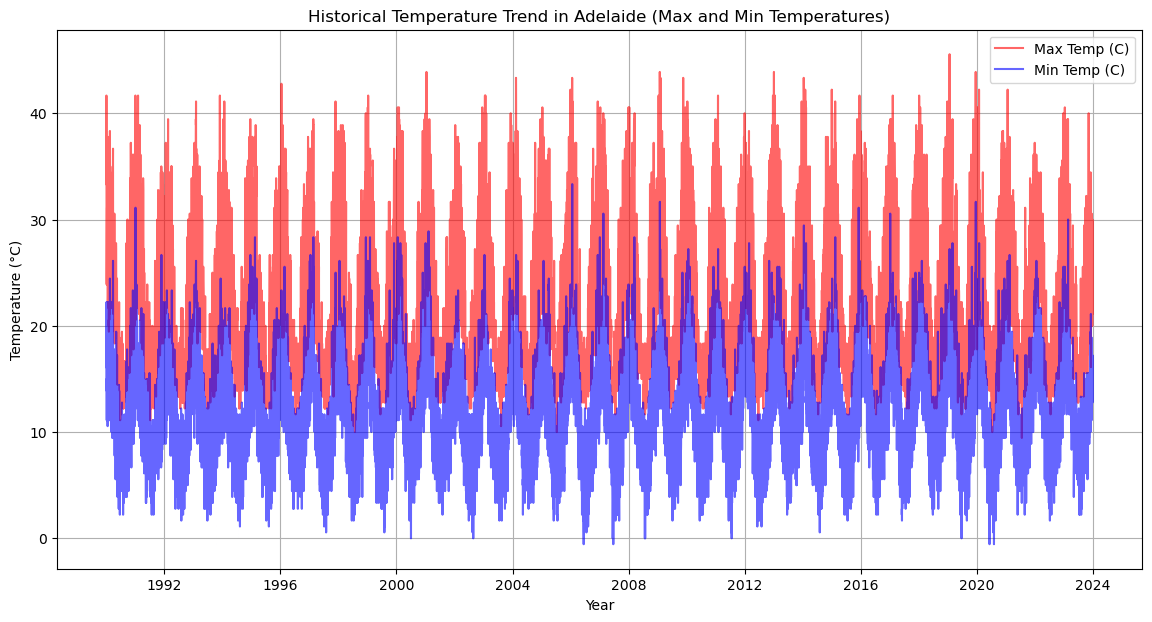

2024-08-29 15:18:47,330 - INFO - Historical weather trend analysis completed.
2024-08-29 15:18:47,331 - INFO - Starting seasonal analysis...


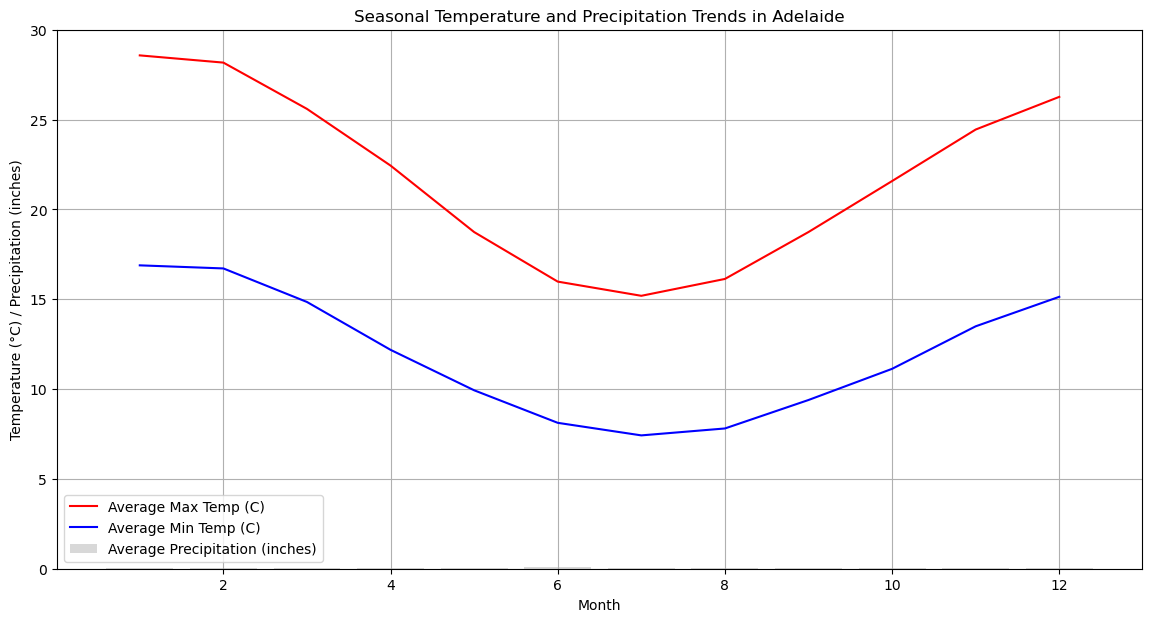

2024-08-29 15:18:47,407 - INFO - Seasonal analysis completed.
2024-08-29 15:18:47,407 - INFO - Starting climate change analysis...


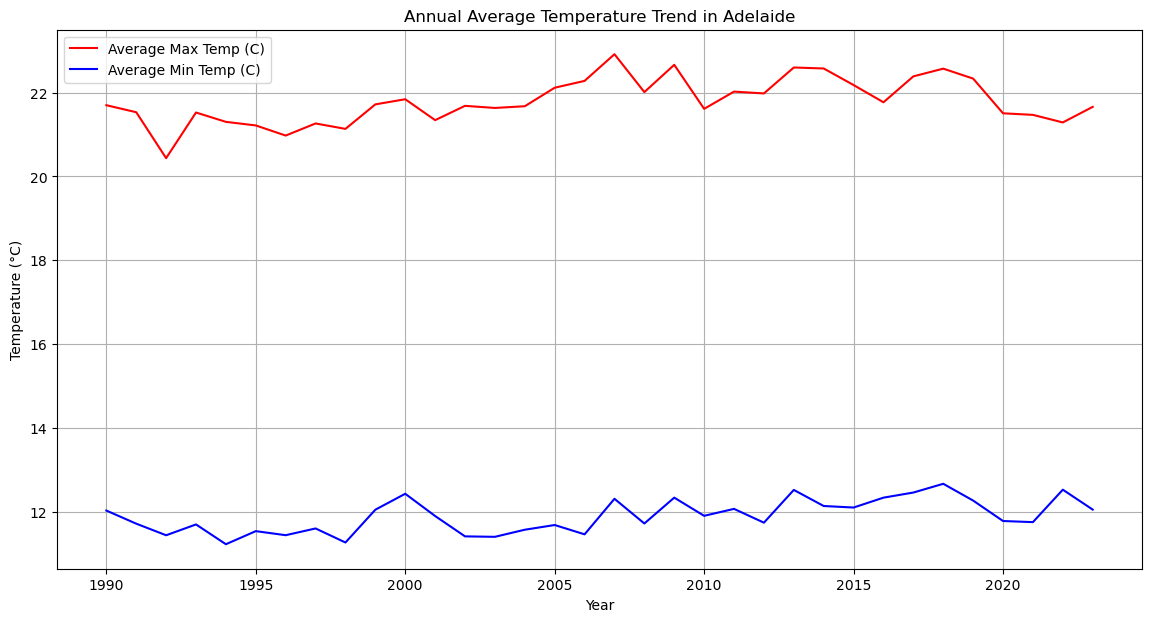

2024-08-29 15:18:47,482 - INFO - Climate change analysis completed.
2024-08-29 15:18:47,483 - INFO - Starting model training with Random Forest...
2024-08-29 15:18:47,493 - INFO - Data split into training and test sets.
2024-08-29 15:21:28,907 - INFO - Model training completed with GridSearchCV.
2024-08-29 15:21:28,923 - INFO - Performing cross-validation...
2024-08-29 15:33:45,422 - INFO - Cross-Validation Score: 0.48273006091811793
2024-08-29 15:33:45,435 - INFO - Making predictions and evaluating the model...
2024-08-29 15:33:45,858 - INFO - Mean Absolute Error: 2.861887214198603
2024-08-29 15:33:46,015 - INFO - Model saved successfully.
2024-08-29 15:33:46,015 - INFO - Generating future weather predictions for the next 7 days...
2024-08-29 15:33:46,038 - INFO - Script completed successfully.



Future Weather Predictions (Next 7 Days):
Date: 2024-08-29 | Predicted Max Temperature: 20.58°C
Date: 2024-08-30 | Predicted Max Temperature: 17.72°C
Date: 2024-08-31 | Predicted Max Temperature: 16.66°C
Date: 2024-09-01 | Predicted Max Temperature: 19.80°C
Date: 2024-09-02 | Predicted Max Temperature: 20.79°C
Date: 2024-09-03 | Predicted Max Temperature: 19.63°C
Date: 2024-09-04 | Predicted Max Temperature: 17.12°C

Summary of Findings:
1. The overall historical trend shows a general increase in both maximum and minimum temperatures over the years in Adelaide.
2. Seasonal analysis reveals that the hottest months are typically January and February, with the coldest being July.
3. Climate change indicators suggest a gradual increase in average annual temperatures, indicating warming trends.
4. The improved predictive model using Random Forest has a Mean Absolute Error (MAE) of 2.86°C, indicating good predictive accuracy.
5. Future weather predictions for the next week have been generat

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the weather data
logging.info("Loading weather data...")
weather_data_df = pd.read_csv('adelaide_weather_data.csv')

# Feature Engineering: Adding Day of the Year for more seasonality insights
logging.info("Performing feature engineering...")
weather_data_df['Date'] = pd.to_datetime(weather_data_df[['Year', 'Month', 'Day']])
weather_data_df['DayOfYear'] = weather_data_df['Date'].dt.dayofyear

# 1. Historical Weather Trend Analysis
logging.info("Starting historical weather trend analysis...")
plt.figure(figsize=(14, 7))
plt.plot(weather_data_df['Date'], weather_data_df['Max Temp (C)'], label='Max Temp (C)', color='red', alpha=0.6)
plt.plot(weather_data_df['Date'], weather_data_df['Min Temp (C)'], label='Min Temp (C)', color='blue', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Historical Temperature Trend in Adelaide (Max and Min Temperatures)')
plt.legend()
plt.grid(True)
plt.show()
logging.info("Historical weather trend analysis completed.")

# 2. Seasonal Analysis: Average Temperature and Precipitation by Month
logging.info("Starting seasonal analysis...")
seasonal_avg = weather_data_df.groupby('Month')[['Max Temp (C)', 'Min Temp (C)', 'Precipitation (in)']].mean()
plt.figure(figsize=(14, 7))
plt.plot(seasonal_avg.index, seasonal_avg['Max Temp (C)'], label='Average Max Temp (C)', color='red')
plt.plot(seasonal_avg.index, seasonal_avg['Min Temp (C)'], label='Average Min Temp (C)', color='blue')
plt.bar(seasonal_avg.index, seasonal_avg['Precipitation (in)'], color='gray', alpha=0.3, label='Average Precipitation (inches)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C) / Precipitation (inches)')
plt.title('Seasonal Temperature and Precipitation Trends in Adelaide')
plt.legend()
plt.grid(True)
plt.show()
logging.info("Seasonal analysis completed.")

# 3. Climate Change Analysis: Annual Average Temperature Trend
logging.info("Starting climate change analysis...")
annual_avg_temp = weather_data_df.groupby('Year')[['Max Temp (C)', 'Min Temp (C)']].mean()
plt.figure(figsize=(14, 7))
plt.plot(annual_avg_temp.index, annual_avg_temp['Max Temp (C)'], label='Average Max Temp (C)', color='red')
plt.plot(annual_avg_temp.index, annual_avg_temp['Min Temp (C)'], label='Average Min Temp (C)', color='blue')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Annual Average Temperature Trend in Adelaide')
plt.legend()
plt.grid(True)
plt.show()
logging.info("Climate change analysis completed.")

# 4. Improved Predictive Model with Random Forest
logging.info("Starting model training with Random Forest...")
X = weather_data_df[['Year', 'Month', 'Day', 'DayOfYear']]
y = weather_data_df['Max Temp (C)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logging.info("Data split into training and test sets.")

# Random Forest model with GridSearch for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
rf_model.fit(X_train, y_train)
logging.info("Model training completed with GridSearchCV.")

# Cross-validation score
logging.info("Performing cross-validation...")
cv_score = cross_val_score(rf_model, X, y, cv=5)
logging.info(f"Cross-Validation Score: {cv_score.mean()}")

# Predictions and evaluation
logging.info("Making predictions and evaluating the model...")
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
logging.info(f"Mean Absolute Error: {mae}")

# Save the model for future use
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
logging.info("Model saved successfully.")

# 5. Future Weather Predictions
logging.info("Generating future weather predictions for the next 7 days...")
today = datetime.today()
dates = [today + timedelta(days=i) for i in range(7)]
prediction_data = pd.DataFrame({
    'Year': [date.year for date in dates],
    'Month': [date.month for date in dates],
    'Day': [date.day for date in dates],
    'DayOfYear': [date.timetuple().tm_yday for date in dates]
})
predicted_temps = rf_model.predict(prediction_data)

# Ensuring Text Output
output_text = "\nFuture Weather Predictions (Next 7 Days):\n"
for date, temp in zip(dates, predicted_temps):
    output_text += f"Date: {date.strftime('%Y-%m-%d')} | Predicted Max Temperature: {temp:.2f}°C\n"

output_text += "\nSummary of Findings:\n"
output_text += f"1. The overall historical trend shows a general increase in both maximum and minimum temperatures over the years in Adelaide.\n"
output_text += f"2. Seasonal analysis reveals that the hottest months are typically January and February, with the coldest being July.\n"
output_text += f"3. Climate change indicators suggest a gradual increase in average annual temperatures, indicating warming trends.\n"
output_text += f"4. The improved predictive model using Random Forest has a Mean Absolute Error (MAE) of {mae:.2f}°C, indicating good predictive accuracy.\n"
output_text += "5. Future weather predictions for the next week have been generated successfully, demonstrating the model's practical application.\n"

print(output_text)
logging.info("Script completed successfully.")
